In [2]:
!pip install --quiet tinydb
!pip install --upgrade --quiet numpy

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
%matplotlib inline
from tinydb import TinyDB
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation
from collections import Counter
import seaborn as sns

In [4]:
records_taken_together = TinyDB('db_parsed_taken_together.json').all()
records_pd_taken_together = pd.DataFrame(records_taken_together).drop_duplicates()
print('number of unique records', records_pd_taken_together.shape)

number of unique records (385227, 2)


#  Process data
Convert a collection of generic_name documents as defined in `https://open.fda.gov/apis/drug/label/searchable-fields` to a matrix of token counts.

In [5]:
vectoriser_taken_together = CountVectorizer(min_df=5, max_df=0.2, 
                                            binary=True, 
                                            token_pattern=r"(?u)[\w -]+", 
                                            dtype=np.bool)
matrix_taken_together= vectoriser_taken_together.fit_transform(records_pd_taken_together['generic_name'])
X_taken_together = matrix_taken_together.toarray()
print('Drugs count matrix size:', X_taken_together.shape)

Drugs count matrix size: (385227, 1674)


In [6]:
ind_taken_together = np.where(X_taken_together.sum(1)>3)
x_taken_together_filt = X_taken_together[ind_taken_together[0],]
print('Filtered drugs count matrix size:', x_taken_together_filt.shape)
dist_taken_together = pairwise_distances(x_taken_together_filt.T, metric='jaccard')

Filtered drugs count matrix size: (19991, 1674)


In [7]:
dist_taken_together_norm = np.nan_to_num(dist_taken_together, nan=1.0)

#  Clustering
Use Affinity Propagation (`https://science.sciencemag.org/content/315/5814/972`) to identify clusters of drugs that tend to be taken together

In [8]:
clustering = AffinityPropagation().fit_predict(dist_taken_together_norm)

#  Results

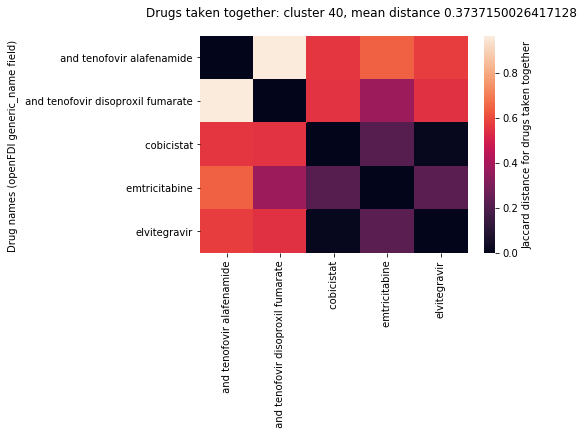

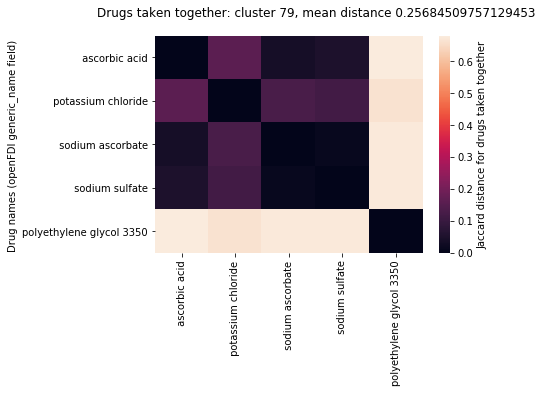

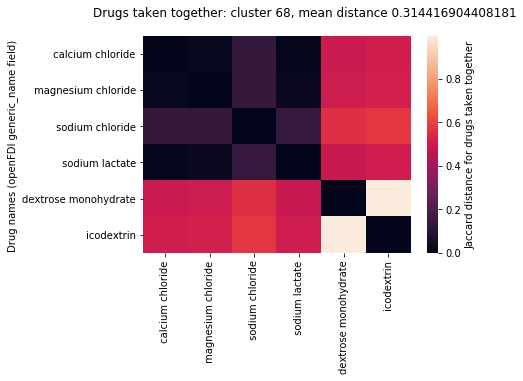

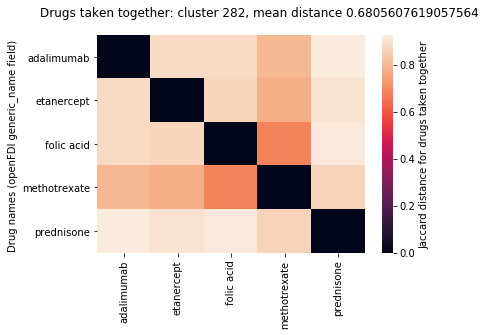

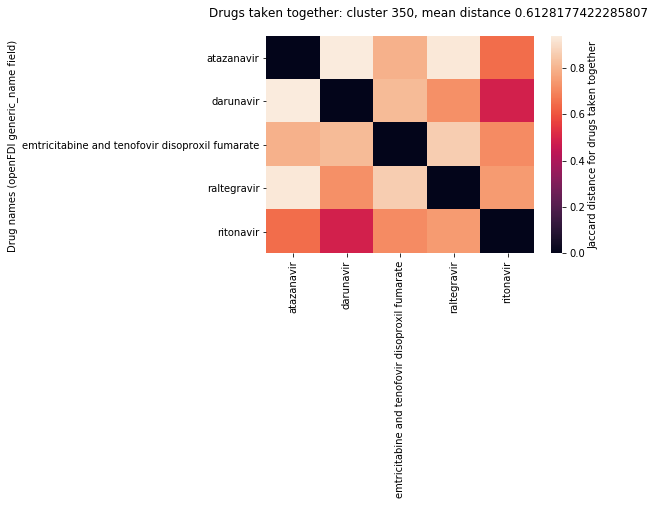

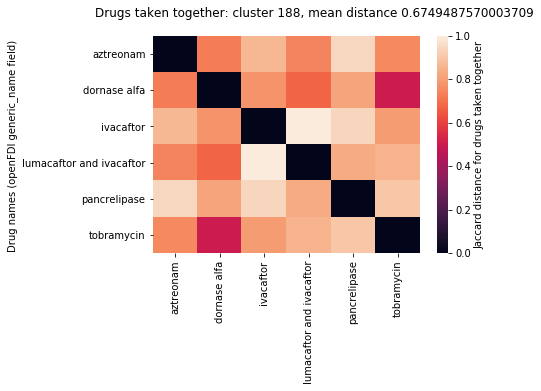

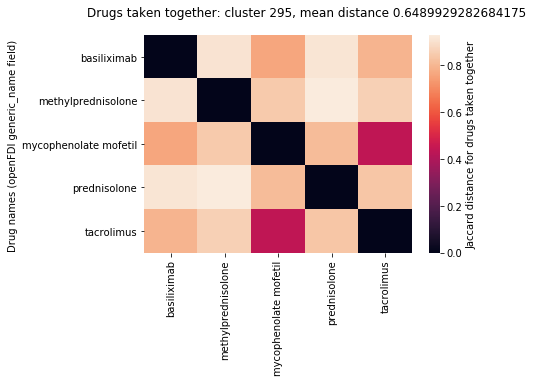

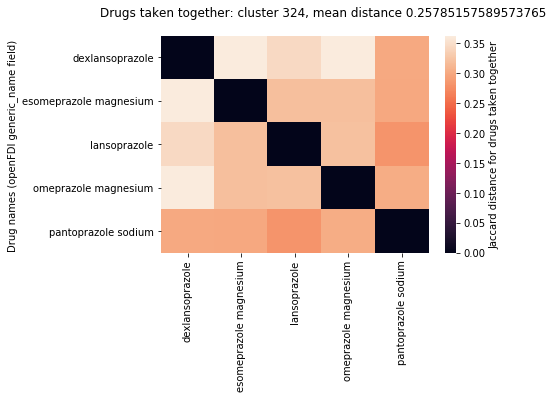

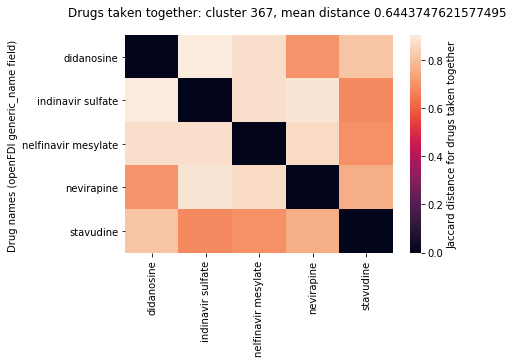

In [35]:
clusters = []
drug_names = vectoriser_taken_together.get_feature_names()
for cluster_index, occurence in dict(Counter(clustering)).items():
    ind = np.where(clustering==cluster_index)[0]
    dist_mat = dist_taken_together_norm[np.ix_(ind, ind)] 
    mean_dist = dist_mat.mean()
    if mean_dist < 0.7 and occurence > 4 and mean_dist > 0:
        drug_name = np.array(drug_names)[ind]
        cluster = {}
        cluster['cluster_id'] = cluster_index
        cluster['drugs'] = ' '.join(list(drug_name))
        cluster['mean_dist'] = mean_dist
        clusters.append(cluster)
        fig = plt.figure()
        fig.suptitle(f'Drugs taken together: cluster {cluster_index}, mean distance {mean_dist}')
        sns.heatmap(dist_mat, xticklabels=drug_name, yticklabels=drug_name, cbar_kws={'label': 'Jaccard distance for drugs taken together'})
        plt.ylabel('Drug names (openFDI generic_name field) ')

In [16]:
clusters_pd = pd.DataFrame(clusters)

In [24]:
pd.set_option('display.max_colwidth', 130)
clusters_pd

,cluster_id,drugs,mean_dist
0,40,and tenofovir alafenamide and tenofovir disoproxil fumarate cobicistat emtricitabine elvitegravir,0.373715
1,79,ascorbic acid potassium chloride sodium ascorbate sodium sulfate polyethylene glycol 3350,0.256845
2,68,calcium chloride magnesium chloride sodium chloride sodium lactate dextrose monohydrate icodextrin,0.314417
3,282,adalimumab etanercept folic acid methotrexate prednisone,0.680561
4,350,atazanavir darunavir emtricitabine and tenofovir disoproxil fumarate raltegravir ritonavir,0.612818
5,188,aztreonam dornase alfa ivacaftor lumacaftor and ivacaftor pancrelipase tobramycin,0.674949
6,295,basiliximab methylprednisolone mycophenolate mofetil prednisolone tacrolimus,0.648993
7,324,dexlansoprazole esomeprazole magnesium lansoprazole omeprazole magnesium pantoprazole sodium,0.257852
8,367,didanosine indinavir sulfate nelfinavir mesylate nevirapine stavudine,0.644375


In [27]:
clusters_pd.to_csv('drugs_taken_together.csv')